### ARIMA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

%matplotlib inline
plt.style.use('seaborn-bright')

### Loading CSV

Load CSV and set index to datetime

In [2]:
from datetime import datetime

# Only selecting only relevant columns year (1), month (2), day (3), hour (4), pm2.5 (5), dewp (6), temp (7), pres (8), lws (10)
selected_column = ['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']

data = pd.read_csv('Haze.csv', parse_dates = [['year', 'month', 'day', 'hour']],\
                   date_parser = lambda x : datetime.strptime(x, '%Y %m %d %H'),\
                   usecols = selected_column)

# Rename columns
renamed_column = ['time', 'pm2_5', 'dewPoint', 'temp', 'pressure', 'wind_speed']
data.columns = renamed_column

# Set index as time
data.set_index('time', drop = True, inplace = True)

### Drop rows without pm2_5 values since it is the predictor value

It seems like the first day of 2010 has no value, but it is ok to drop it, since there is still many many more data points

In [3]:
data.dropna(axis = 0, inplace = True)

data.describe()

,pm2_5,dewPoint,temp,pressure,wind_speed
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,98.613215,1.750174,12.401561,1016.442896,23.866747
std,92.050387,14.433658,12.175215,10.300733,49.617495
min,0.000000,-40.000000,-19.000000,991.000000,0.450000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000
max,994.000000,28.000000,42.000000,1046.000000,565.490000


In [4]:
data['pm2_5'].isnull().sum()

0

### Resampling

There are some days that don't have pm2.5 reading, in such case, we will interpolate these data from the previous reading.

** We are downsampling the data to day resolution **

In [5]:
data = data.resample('D').interpolate('time')

### From EDA, we will take a difference of 365 days

In [6]:
ndata = data.diff(periods = 365).dropna()

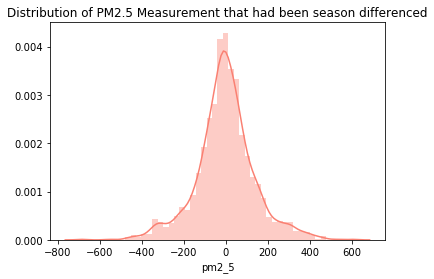

In [7]:
plt.title('Distribution of PM2.5 Measurement that had been season differenced')
sns.distplot(ndata['pm2_5'], color = 'salmon')

### Set aside 14 days to predict

In [8]:
TESTDAYS = 14
train, test = ndata[:-TESTDAYS], ndata[-TESTDAYS:]

train.shape, test.shape

((1446, 5), (14, 5))

In [9]:
train.head()

,pm2_5,dewPoint,temp,pressure,wind_speed
time,,,,,
2011-01-02,-93.0,-1.0,-3.0,17.0,73.31
2011-01-03,-25.0,-8.0,-1.0,6.0,-57.67
2011-01-04,154.0,-1.0,2.0,6.0,-13.41
2011-01-05,-2.0,7.0,12.0,-6.0,-126.03
2011-01-06,-43.0,6.0,11.0,4.0,256.12


#### Looping through values of p, d, q

Get different combinations of p, d and q from 0 to 3 fit into ARIMA and get the combinations with the lowest AIC score

In [10]:
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 4)

# Generate all different combinations of p, q and d triplets
pdq = list(itertools.product(p, d, q))

pdq_list = []
aic_list = []

for order in pdq:
    try:
        # Fit ARIMA model with p, d, q
        model = ARIMA(train['pm2_5'], order = order)
        results = model.fit()
        
        # Print results
        print('ARIMA{} - AIC:{}'.format(order, results.aic))
        pdq_list.append(order)
        aic_list.append(results.aic)
    except:
        continue

C:\Users\Lee Jiahe Steven\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ARIMA(0, 0, 0) - AIC:18417.31835713813
ARIMA(0, 0, 1) - AIC:18216.651119098962
ARIMA(0, 0, 2) - AIC:18214.87696110798
ARIMA(0, 0, 3) - AIC:18201.88657531614
ARIMA(0, 1, 0) - AIC:18746.969115170617
ARIMA(0, 1, 1) - AIC:18414.766147726812
ARIMA(0, 1, 2) - AIC:18213.652275011416
ARIMA(0, 1, 3) - AIC:18211.800253112844
ARIMA(0, 2, 0) - AIC:20106.666828569654
ARIMA(0, 2, 1) - AIC:18744.261395751277
ARIMA(1, 0, 0) - AIC:18211.89213756629
ARIMA(1, 0, 1) - AIC:18211.433148404703
ARIMA(1, 0, 2) - AIC:18211.80548930402
ARIMA(1, 1, 0) - AIC:18619.50156305014
ARIMA(1, 1, 1) - AIC:18208.63244935714
ARIMA(1, 1, 2) - AIC:18208.25537569105
ARIMA(1, 1, 3) - AIC:18208.58657729774
ARIMA(1, 2, 0) - AIC:19590.858092322072
ARIMA(2, 0, 0) - AIC:18212.017251589692
ARIMA(2, 0, 1) - AIC:18207.483871181408
ARIMA(2, 0, 2) - AIC:18208.2243785324
ARIMA(2, 0, 3) - AIC:18196.845844242
ARIMA(2, 1, 0) - AIC:18505.396410827398
ARIMA(2, 1, 1) - AIC:18208.8253056982
ARIMA(2, 1, 2) - AIC:18204.291254483298
ARIMA(2, 1, 3) -

In [11]:
aic_df = pd.DataFrame({'order': pdq_list , 'aic': aic_list})
aic_df.sort_values(by = 'aic', ascending = True).head()

,aic,order
34,18191.878916,"(3, 1, 3)"
29,18195.149303,"(3, 0, 2)"
21,18196.845844,"(2, 0, 3)"
30,18197.602233,"(3, 0, 3)"
3,18201.886575,"(0, 0, 3)"


In [12]:
model = ARIMA (train['pm2_5'], order = (3, 1, 3))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.pm2_5   No. Observations:                 1445
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -9087.939
Method:                       css-mle   S.D. of innovations            130.066
Date:                Mon, 13 Nov 2017   AIC                          18191.879
Time:                        23:26:10   BIC                          18234.086
Sample:                    01-03-2011   HQIC                         18207.632
                         - 12-17-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0023      0.013      0.178      0.859      -0.023       0.028
ar.L1.D.pm2_5    -0.9422      0.111     -8.522      0.000      -1.159      -0.725
ar.L2.D.pm2_5    -0.2568      0.065     -3.942      0.000      -0.384      -0.129
ar.L3.D.pm2_5     0.2990      0.041      7.347      0.000       0.219       0.379
ma.L1.D.pm2_5     0.3305      0.113      2.918      0.004       0.109       0.552
ma.L2.D.pm2_5    -0.6139      0.089     -6.934      0.000      -0.787      -0.440
ma.L3.D.pm2_5    -0.7165      0.081     -8.843      0.000      -0.875      -0.558
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8613           -0.7442j            1.1383           -0.3866
AR.2           -0.8613           +0.7442j            1.1383            0.3866
AR.3            2.5817           -0.0000j            2.5817           -0.0000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.9284           -0.7305j            1.1814           -0.3939
MA.3           -0.9284           +0.7305j            1.1814            0.3939
-----------------------------------------------------------------------------
"""

### Predicted results

In [13]:
# Get predicted values for 14 days
pred = result.predict(start = test.index[0], end = test.index[-1])
pred

2014-12-18    199.908797
2014-12-19     44.052065
2014-12-20     45.763688
2014-12-21      5.337968
2014-12-22     -3.608076
2014-12-23     15.714154
2014-12-24    -12.278367
2014-12-25      6.458320
2014-12-26      1.770753
2014-12-27     -6.993145
2014-12-28      8.069068
2014-12-29     -5.272579
2014-12-30      0.809158
2014-12-31      3.008439
Freq: D, dtype: float64

### Residual plot

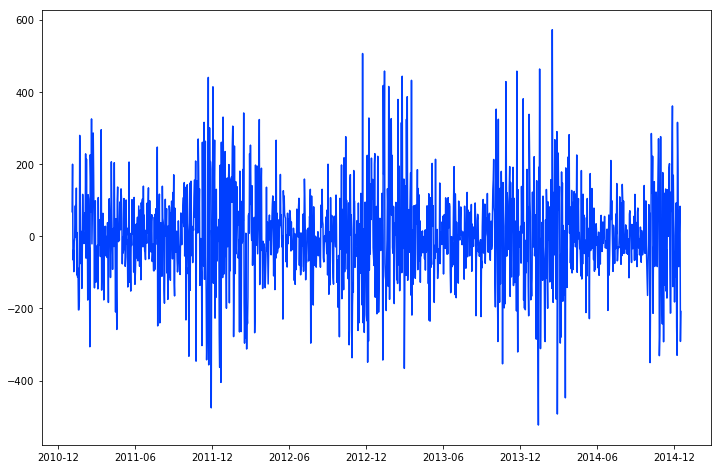

In [14]:
plt.figure(figsize = (12, 8))
plt.plot(result.resid)

### Residual Normality

In [15]:
from scipy import stats

stats.normaltest(result.resid)

NormaltestResult(statistic=57.568511464744368, pvalue=3.1561422553827246e-13)

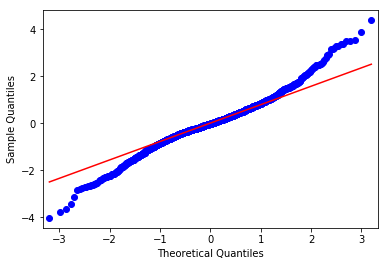

In [16]:
from statsmodels.graphics.api import qqplot

qqplot(result.resid, line = 'q', fit = True)
plt.show()

In [17]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(result.resid.values)

1.9855518882419787

### Transform data back by adding the previous year results

In [18]:
y_test = test['pm2_5'] + data.loc['2013-12', 'pm2_5'].tail(14).values

### Transform predicted data by adding previous year results

In [19]:
y_pred = pred + + data.loc['2013-12', 'pm2_5'].tail(14).values

### Get mean squared error

In [20]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

191.78781348437082

### Plot Test Results

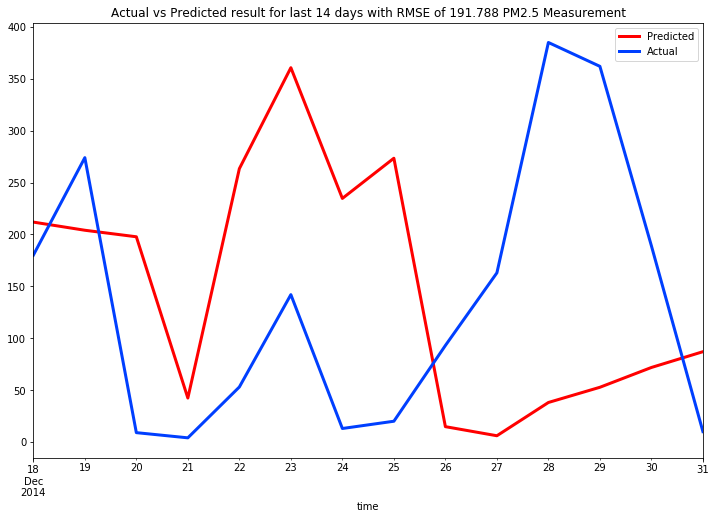

In [21]:
plt.figure(figsize = (12, 8))
plt.title('Actual vs Predicted result for last 14 days with RMSE of {:.3f} PM2.5 Measurement'.format(rmse))
y_pred.plot(color = 'r', lw = 3, label = 'Predicted')
y_test.plot(lw = 3, label = 'Actual')
plt.legend(loc = 'best')
plt.show()